# 1. Importing modules and functions

In [25]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from molvs import standardize_smiles
from copy import deepcopy
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import permutation_test_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import joblib
import pickle
from numpy import savetxt
from padelpy import from_sdf
import shap
from tqdm.notebook import tqdm

In [26]:
def convert_smi_to_canon_smi(smi):
    
    try:
        canon_smi = Chem.MolToSmiles(Chem.MolFromSmiles(smi),isomericSmiles = False)
    except:
        canon_smi='wrong_smiles'
    return canon_smi

In [27]:
def standart(smi):
    global m
    if smi!='wrong_smiles':
        try:
            smiles=standardize_smiles(smi)
            m = Chem.MolFromSmiles(smi)
        except:
            smi='error kekule'
    else:
        m = 'check the smiles'
    return m

## Load data and curation work set

In [28]:
# Set file path
df_ws=pd.read_csv('rat_oral_LD50_WS.csv')
df_ws

,CAS_Number,SMILES,pLD50,"LD50,mg/kg"
0,626-48-2,Cc1cc(=O)[nH]c(=O)[nH]1,0.291207,64463.0000
1,27849-94-1,CC(CCc1ccc2c(c1)OCO2)NN,0.440660,75449.0000
2,110-54-3,CCCCCC,0.537460,24980.0000
3,1330-92-3,CCCCC(CC)COC(=O)C1=C(C(=O)OCC(CC)CCCC)CCCC1,0.539250,113917.0000
4,57-55-6,CC(O)CO,0.580330,19989.0000
...,...,...,...,...
7707,56073-10-0,O=c1oc2ccccc2c(O)c1C1CC(c2ccc(-c3ccc(Br)cc3)cc...,6.514700,0.1596
7708,130209-82-4,CC(C)OC(=O)CCC/C=C/CC1C(O)CC(O)C1CCC(O)CCc1ccccc1,6.937100,0.0500
7709,83805-11-2,C=C1/C(=C\C=C2/CCCC3(C)C2CCC3C(C)CCCC(O)(C(F)(...,7.099700,0.0417
7710,1746-01-6,Clc1cc2c(cc1Cl)Oc1cc(Cl)c(Cl)cc1O2,7.206800,0.0199


 Convert a SMILES string to canonical SMILES

In [29]:
df_ws1 = deepcopy(df_ws)
df_ws1["SMILES"] = df_ws1.apply(lambda x: convert_smi_to_canon_smi(x.SMILES), axis=1)
df_ws1

,CAS_Number,SMILES,pLD50,"LD50,mg/kg"
0,626-48-2,Cc1cc(=O)[nH]c(=O)[nH]1,0.291207,64463.0000
1,27849-94-1,CC(CCc1ccc2c(c1)OCO2)NN,0.440660,75449.0000
2,110-54-3,CCCCCC,0.537460,24980.0000
3,1330-92-3,CCCCC(CC)COC(=O)C1=C(C(=O)OCC(CC)CCCC)CCCC1,0.539250,113917.0000
4,57-55-6,CC(O)CO,0.580330,19989.0000
...,...,...,...,...
7707,56073-10-0,O=c1oc2ccccc2c(O)c1C1CC(c2ccc(-c3ccc(Br)cc3)cc...,6.514700,0.1596
7708,130209-82-4,CC(C)OC(=O)CCCC=CCC1C(O)CC(O)C1CCC(O)CCc1ccccc1,6.937100,0.0500
7709,83805-11-2,C=C1C(=CC=C2CCCC3(C)C2CCC3C(C)CCCC(O)(C(F)(F)F...,7.099700,0.0417
7710,1746-01-6,Clc1cc2c(cc1Cl)Oc1cc(Cl)c(Cl)cc1O2,7.206800,0.0199


In [30]:
print('Original data: ', len(df_ws), 'molecules')
print('Failed data: ', len(df_ws1[df_ws1['SMILES']=='wrong_smiles']), 'molecules')

Original data:  7712 molecules
Failed data:  0 molecules


In [31]:
index=df_ws1.index[df_ws1['SMILES']=='wrong_smiles'].tolist()
wrong_smiles=df_ws.iloc[index]
wrong_smiles=wrong_smiles.SMILES
number=[x+1 for x in index]
bad_molecules = pd.DataFrame({'No. failed smiles in original set': number, 'SMILES of wrong structure: ': wrong_smiles}, index=None)
bad_molecules = bad_molecules.set_index('No. failed smiles in original set')
bad_molecules

,SMILES of wrong structure:
No. failed smiles in original set,


##  Standardization  for work set

In [37]:
df_ws1["Molecule"] = df_ws1.apply(lambda x: standart(x.SMILES), axis=1)
moldf_ws=df_ws1[df_ws1['SMILES']!='wrong_smiles']
print('Kept data: ', len(moldf_ws), 'molecules')

Kept data:  7712 molecules


In [38]:
moldf_ws

,CAS_Number,SMILES,pLD50,"LD50,mg/kg",Molecule
0,626-48-2,Cc1cc(=O)[nH]c(=O)[nH]1,0.291207,64463.0000,<rdkit.Chem.rdchem.Mol object at 0x000001DD424...
1,27849-94-1,CC(CCc1ccc2c(c1)OCO2)NN,0.440660,75449.0000,<rdkit.Chem.rdchem.Mol object at 0x000001DD424...
2,110-54-3,CCCCCC,0.537460,24980.0000,<rdkit.Chem.rdchem.Mol object at 0x000001DD424...
3,1330-92-3,CCCCC(CC)COC(=O)C1=C(C(=O)OCC(CC)CCCC)CCCC1,0.539250,113917.0000,<rdkit.Chem.rdchem.Mol object at 0x000001DD424...
4,57-55-6,CC(O)CO,0.580330,19989.0000,<rdkit.Chem.rdchem.Mol object at 0x000001DD424...
...,...,...,...,...,...
7707,56073-10-0,O=c1oc2ccccc2c(O)c1C1CC(c2ccc(-c3ccc(Br)cc3)cc...,6.514700,0.1596,<rdkit.Chem.rdchem.Mol object at 0x000001DD4A3...
7708,130209-82-4,CC(C)OC(=O)CCCC=CCC1C(O)CC(O)C1CCC(O)CCc1ccccc1,6.937100,0.0500,<rdkit.Chem.rdchem.Mol object at 0x000001DD4A3...
7709,83805-11-2,C=C1C(=CC=C2CCCC3(C)C2CCC3C(C)CCCC(O)(C(F)(F)F...,7.099700,0.0417,<rdkit.Chem.rdchem.Mol object at 0x000001DD4A3...
7710,1746-01-6,Clc1cc2c(cc1Cl)Oc1cc(Cl)c(Cl)cc1O2,7.206800,0.0199,<rdkit.Chem.rdchem.Mol object at 0x000001DD4A3...


In [39]:
y_tr=moldf_ws.pLD50
y_tr

0       0.291207
1       0.440660
2       0.537460
3       0.539250
4       0.580330
          ...   
7707    6.514700
7708    6.937100
7709    7.099700
7710    7.206800
7711    7.602600
Name: pLD50, Length: 7712, dtype: float64

In [40]:
df = pd.DataFrame(moldf_ws, columns=["SMILES"])
df

,SMILES
0,Cc1cc(=O)[nH]c(=O)[nH]1
1,CC(CCc1ccc2c(c1)OCO2)NN
2,CCCCCC
3,CCCCC(CC)COC(=O)C1=C(C(=O)OCC(CC)CCCC)CCCC1
4,CC(O)CO
...,...
7707,O=c1oc2ccccc2c(O)c1C1CC(c2ccc(-c3ccc(Br)cc3)cc...
7708,CC(C)OC(=O)CCCC=CCC1C(O)CC(O)C1CCC(O)CCc1ccccc1
7709,C=C1C(=CC=C2CCCC3(C)C2CCC3C(C)CCCC(O)(C(F)(F)F...
7710,Clc1cc2c(cc1Cl)Oc1cc(Cl)c(Cl)cc1O2


In [41]:
df.to_csv('datasets/molecule_ws.smi', sep=',', index=False, header=False)

##  Load data and curation test set

In [42]:
df_ts=pd.read_csv('rat_oral_LD50_TS.csv')
df_ts

,CAS_Number,SMILES,pLD50,"LD50,mg/kg"
0,7782-40-3,C,0.017765,15388.8000
1,2842-38-8,OCCNC1CCCCC1,0.572840,38274.0000
2,66257-53-2,NC(=O)C(=O)O,0.624490,21133.0000
3,2173-56-0,CCCCCOC(=O)CCCC,0.686960,35395.0000
4,4726-93-6,O=C1CCCCC(=O)N1,0.750180,22586.0000
...,...,...,...,...
1924,3385-03-3,CC1(C)OC2CC3C4CC(F)C5=CC(=O)C=CC5(C)C4C(O)CC3(...,5.939000,0.4997
1925,2338-29-6,FC(F)(F)c1nc2c(Cl)c(Cl)c(Cl)c(Cl)c2[nH]1,6.121300,0.2435
1926,128606-48-4,CCOP(=S)(OCC)O/C(C)=C/C(=O)OC,6.282400,0.1399
1927,50585-41-6,Brc1cc2c(cc1Br)Oc1cc(Br)c(Br)cc1O2,6.698800,0.0992


 Convert a SMILES string to canonical SMILES

In [43]:
df_ts1 = deepcopy(df_ts)
df_ts1["SMILES"] = df_ts1.apply(lambda x: convert_smi_to_canon_smi(x.SMILES), axis=1)
df_ts1

,CAS_Number,SMILES,pLD50,"LD50,mg/kg"
0,7782-40-3,C,0.017765,15388.8000
1,2842-38-8,OCCNC1CCCCC1,0.572840,38274.0000
2,66257-53-2,NC(=O)C(=O)O,0.624490,21133.0000
3,2173-56-0,CCCCCOC(=O)CCCC,0.686960,35395.0000
4,4726-93-6,O=C1CCCCC(=O)N1,0.750180,22586.0000
...,...,...,...,...
1924,3385-03-3,CC1(C)OC2CC3C4CC(F)C5=CC(=O)C=CC5(C)C4C(O)CC3(...,5.939000,0.4997
1925,2338-29-6,FC(F)(F)c1nc2c(Cl)c(Cl)c(Cl)c(Cl)c2[nH]1,6.121300,0.2435
1926,128606-48-4,CCOP(=S)(OCC)OC(C)=CC(=O)OC,6.282400,0.1399
1927,50585-41-6,Brc1cc2c(cc1Br)Oc1cc(Br)c(Br)cc1O2,6.698800,0.0992


In [44]:
print('Original data: ', len(df_ts), 'molecules')
print('Failed data: ', len(df_ts1[df_ts1['SMILES']=='wrong_smiles']), 'molecules')

Original data:  1929 molecules
Failed data:  0 molecules


In [45]:
index=df_ts1.index[df_ts1['SMILES']=='wrong_smiles'].tolist()
wrong_smiles=df_ts.iloc[index]
wrong_smiles=wrong_smiles.SMILES
number=[x+1 for x in index]
bad_molecules = pd.DataFrame({'No. failed smiles in original set': number, 'SMILES of wrong structure: ': wrong_smiles}, index=None)
bad_molecules = bad_molecules.set_index('No. failed smiles in original set')
bad_molecules

,SMILES of wrong structure:
No. failed smiles in original set,


##  Standardization  for test set

In [46]:
df_ts1["Molecule"] = df_ts1.apply(lambda x: standart(x.SMILES), axis=1)
moldf_ts=df_ts1[df_ts1['SMILES']!='wrong_smiles']
print('Kept data: ', len(moldf_ts), 'molecules')

Kept data:  1929 molecules


In [47]:
moldf_ts

,CAS_Number,SMILES,pLD50,"LD50,mg/kg",Molecule
0,7782-40-3,C,0.017765,15388.8000,<rdkit.Chem.rdchem.Mol object at 0x000001DD4A3...
1,2842-38-8,OCCNC1CCCCC1,0.572840,38274.0000,<rdkit.Chem.rdchem.Mol object at 0x000001DD421...
2,66257-53-2,NC(=O)C(=O)O,0.624490,21133.0000,<rdkit.Chem.rdchem.Mol object at 0x000001DD421...
3,2173-56-0,CCCCCOC(=O)CCCC,0.686960,35395.0000,<rdkit.Chem.rdchem.Mol object at 0x000001DD421...
4,4726-93-6,O=C1CCCCC(=O)N1,0.750180,22586.0000,<rdkit.Chem.rdchem.Mol object at 0x000001DD421...
...,...,...,...,...,...
1924,3385-03-3,CC1(C)OC2CC3C4CC(F)C5=CC(=O)C=CC5(C)C4C(O)CC3(...,5.939000,0.4997,<rdkit.Chem.rdchem.Mol object at 0x000001DD4A3...
1925,2338-29-6,FC(F)(F)c1nc2c(Cl)c(Cl)c(Cl)c(Cl)c2[nH]1,6.121300,0.2435,<rdkit.Chem.rdchem.Mol object at 0x000001DD4A3...
1926,128606-48-4,CCOP(=S)(OCC)OC(C)=CC(=O)OC,6.282400,0.1399,<rdkit.Chem.rdchem.Mol object at 0x000001DD4A3...
1927,50585-41-6,Brc1cc2c(cc1Br)Oc1cc(Br)c(Br)cc1O2,6.698800,0.0992,<rdkit.Chem.rdchem.Mol object at 0x000001DD4A3...


In [48]:
y_ts=moldf_ts.pLD50
y_ts

0       0.017765
1       0.572840
2       0.624490
3       0.686960
4       0.750180
          ...   
1924    5.939000
1925    6.121300
1926    6.282400
1927    6.698800
1928    9.541100
Name: pLD50, Length: 1929, dtype: float64

In [49]:
df_ts = pd.DataFrame(moldf_ts, columns=["SMILES"])
df_ts

,SMILES
0,C
1,OCCNC1CCCCC1
2,NC(=O)C(=O)O
3,CCCCCOC(=O)CCCC
4,O=C1CCCCC(=O)N1
...,...
1924,CC1(C)OC2CC3C4CC(F)C5=CC(=O)C=CC5(C)C4C(O)CC3(...
1925,FC(F)(F)c1nc2c(Cl)c(Cl)c(Cl)c(Cl)c2[nH]1
1926,CCOP(=S)(OCC)OC(C)=CC(=O)OC
1927,Brc1cc2c(cc1Br)Oc1cc(Br)c(Br)cc1O2


In [50]:
df_ts.to_csv('datasets/molecule_ts.smi', sep=',', index=False, header=False)

# Calculation Fingerprints for work set

In [51]:
import glob
xml_files = glob.glob("fingerprints_xml/*.xml")
xml_files.sort()
xml_files

['fingerprints_xml\\AtomPairs2DFingerprintCount.xml',
 'fingerprints_xml\\AtomPairs2DFingerprinter.xml',
 'fingerprints_xml\\EStateFingerprinter.xml',
 'fingerprints_xml\\ExtendedFingerprinter.xml',
 'fingerprints_xml\\Fingerprinter.xml',
 'fingerprints_xml\\GraphOnlyFingerprinter.xml',
 'fingerprints_xml\\KlekotaRothFingerprintCount.xml',
 'fingerprints_xml\\KlekotaRothFingerprinter.xml',
 'fingerprints_xml\\MACCSFingerprinter.xml',
 'fingerprints_xml\\PubchemFingerprinter.xml',
 'fingerprints_xml\\SubstructureFingerprintCount.xml',
 'fingerprints_xml\\SubstructureFingerprinter.xml']

In [52]:
FP_list = ['AtomPairs2DCount',
 'AtomPairs2D',
 'EState',
 'CDKextended',
 'CDK',
 'CDKgraphonly',
 'KlekotaRothCount',
 'KlekotaRoth',
 'MACCS',
 'PubChem',
 'SubstructureCount',
 'Substructure']

In [53]:
fp = dict(zip(FP_list, xml_files))
fp

{'AtomPairs2DCount': 'fingerprints_xml\\AtomPairs2DFingerprintCount.xml',
 'AtomPairs2D': 'fingerprints_xml\\AtomPairs2DFingerprinter.xml',
 'EState': 'fingerprints_xml\\EStateFingerprinter.xml',
 'CDKextended': 'fingerprints_xml\\ExtendedFingerprinter.xml',
 'CDK': 'fingerprints_xml\\Fingerprinter.xml',
 'CDKgraphonly': 'fingerprints_xml\\GraphOnlyFingerprinter.xml',
 'KlekotaRothCount': 'fingerprints_xml\\KlekotaRothFingerprintCount.xml',
 'KlekotaRoth': 'fingerprints_xml\\KlekotaRothFingerprinter.xml',
 'MACCS': 'fingerprints_xml\\MACCSFingerprinter.xml',
 'PubChem': 'fingerprints_xml\\PubchemFingerprinter.xml',
 'SubstructureCount': 'fingerprints_xml\\SubstructureFingerprintCount.xml',
 'Substructure': 'fingerprints_xml\\SubstructureFingerprinter.xml'}

# 6.Descriptor calculation for work set

In [54]:
fp

{'AtomPairs2DCount': 'fingerprints_xml\\AtomPairs2DFingerprintCount.xml',
 'AtomPairs2D': 'fingerprints_xml\\AtomPairs2DFingerprinter.xml',
 'EState': 'fingerprints_xml\\EStateFingerprinter.xml',
 'CDKextended': 'fingerprints_xml\\ExtendedFingerprinter.xml',
 'CDK': 'fingerprints_xml\\Fingerprinter.xml',
 'CDKgraphonly': 'fingerprints_xml\\GraphOnlyFingerprinter.xml',
 'KlekotaRothCount': 'fingerprints_xml\\KlekotaRothFingerprintCount.xml',
 'KlekotaRoth': 'fingerprints_xml\\KlekotaRothFingerprinter.xml',
 'MACCS': 'fingerprints_xml\\MACCSFingerprinter.xml',
 'PubChem': 'fingerprints_xml\\PubchemFingerprinter.xml',
 'SubstructureCount': 'fingerprints_xml\\SubstructureFingerprintCount.xml',
 'Substructure': 'fingerprints_xml\\SubstructureFingerprinter.xml'}

## PubChem FPs

In [55]:
from padelpy import padeldescriptor

fingerprint = 'PubChem'

fingerprint_output_file = ''.join([fingerprint,'.csv']) #Substructure.csv
fingerprint_descriptortypes = fp[fingerprint]

padeldescriptor(mol_dir='datasets/molecule_ws.smi', 
                d_file=fingerprint_output_file, #'Substructure.csv'
                #descriptortypes='SubstructureFingerprint.xml', 
                descriptortypes= fingerprint_descriptortypes,
                detectaromaticity=True,
                standardizenitro=True,
                standardizetautomers=True,
                threads=2,
                removesalt=True,
                log=True,
                fingerprints=True)

In [56]:
descriptors_PubChem = pd.read_csv('PubChem.csv')

In [57]:
descriptors_PubChem

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,AUTOGEN_molecule_ws_1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AUTOGEN_molecule_ws_2,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AUTOGEN_molecule_ws_3,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AUTOGEN_molecule_ws_4,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AUTOGEN_molecule_ws_5,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7707,AUTOGEN_molecule_ws_7708,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7708,AUTOGEN_molecule_ws_7709,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7709,AUTOGEN_molecule_ws_7710,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7710,AUTOGEN_molecule_ws_7711,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
x_tr = descriptors_PubChem.drop('Name', axis=1)

In [59]:
x_tr = np.array(x_tr, dtype=np.float32)
y_tr = np.array(y_tr, dtype=np.float32)

In [62]:
savetxt('models/Padels/x_tr_PubChem.csv', x_tr, delimiter=',')

In [63]:
x_tr.shape

(7712, 881)

# 7.Descriptor calculation for test set

In [64]:
from padelpy import padeldescriptor

fingerprint = 'PubChem'

fingerprint_output_file = ''.join([fingerprint,'_ts.csv']) #PubChem.csv
fingerprint_descriptortypes = fp[fingerprint]

padeldescriptor(mol_dir='datasets/molecule_ts.smi', 
                d_file=fingerprint_output_file, #'PubChem.csv'
                #descriptortypes='PubChem.xml', 
                descriptortypes= fingerprint_descriptortypes,
                detectaromaticity=True,
                standardizenitro=True,
                standardizetautomers=True,
                threads=2,
                removesalt=True,
                log=False,
                fingerprints=True)

In [65]:
descriptors_PubChem_ts = pd.read_csv('PubChem_ts.csv')

In [66]:
x_ts = descriptors_PubChem_ts.drop('Name', axis=1)

In [67]:
x_ts.shape

(1929, 881)

 # GradientBoostingRegressor model building and validation

In [68]:
seed = 42

In [69]:
cv=KFold(n_splits=5, random_state=seed, shuffle=True)

In [70]:
param_grid = {'learning_rate': [0.02,0.05],
                  'subsample'    : [0.9, 0.5, 0.1],
                  'n_estimators' : [100,500,1000],
                  'max_depth'    : [4, 10]
                 }

In [71]:
m = GridSearchCV(GradientBoostingRegressor(), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [72]:
m.fit(x_tr, y_tr)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.02, 0.05], 'max_depth': [4, 10],
                         'n_estimators': [100, 500, 1000],
                         'subsample': [0.9, 0.5, 0.1]},
             verbose=1)

In [73]:
best_GBR = m.best_estimator_

In [74]:
m.best_params_

{'learning_rate': 0.02, 'max_depth': 10, 'n_estimators': 500, 'subsample': 0.5}

In [75]:
y_pred_ws_GBR = best_GBR.predict(x_tr)

In [76]:
R2_WS = round(r2_score(y_tr, y_pred_ws_GBR), 2)
R2_WS

0.9

In [77]:
RMSE_WS=round(np.sqrt(mean_absolute_error(y_tr, y_pred_ws_GBR)), 2)
RMSE_WS

0.47

In [78]:
y_pred_CV_GBR = cross_val_predict(best_GBR, x_tr, y_tr, cv=cv)

In [79]:
y_pred_CV_GBR

array([1.65282279, 2.74096043, 1.56835671, ..., 4.97440389, 4.78439187,
       2.80403106])

In [80]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_GBR), 2)
Q2_CV

0.59

In [81]:
RMSE_CV=round(np.sqrt(mean_absolute_error(y_tr, y_pred_CV_GBR)), 2)
RMSE_CV

0.64

# 9. Prediction for test set's molecules

In [82]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)
len(y_ts)

1929

In [83]:
y_pred_GBR = best_GBR.predict(x_ts)

In [84]:
Q2_TS = round(r2_score(y_ts, y_pred_GBR), 2)
Q2_TS

0.59

In [85]:
RMSE_TS=round(np.sqrt(mean_absolute_error(y_ts, y_pred_GBR)), 2)
RMSE_TS

0.63

# save the model to disk

In [86]:
pickle.dump(best_GBR, open('models/Padels/Toxicitu_GBR_PubChem.pkl', 'wb'))

# load the model from disk

In [26]:
best_GBR = pickle.load(open('models/Padels/Toxicitu_GBR_PubChem.pkl', 'rb'))

# 10. Y-randomization GradientBoostingRegressor model

In [87]:
permutations = 50
score, permutation_scores, pvalue = permutation_test_score(best_GBR, x_tr, y_tr,
                                                           cv=cv, scoring='r2',
                                                           n_permutations=permutations,
                                                           n_jobs=-1,
                                                           verbose=1,
                                                           random_state=seed)
print('True score = ', score.round(2),
      '\nY-randomization = ', np.mean(permutation_scores).round(2),
      '\np-value = ', pvalue.round(4))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed: 87.1min


True score =  0.59 
Y-randomization =  -0.14 
p-value =  0.0196


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 136.6min finished


# 11. Estimating applicability domain. Method - Euclidian distances, K=1

In [88]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [89]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,7702,7703,7704,7705,7706,7707,7708,7709,7710,7711
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2.449490,4.472136,1.000000,3.000000,1.414214,2.645751,3.000000,3.741657,0.000000,1.000000,...,1.414214,1.732051,2.449490,4.582576,2.236068,3.316625,4.898980,3.000000,2.828427,3.316625
2,3.162278,4.582576,1.732051,3.872983,1.414214,3.000000,3.000000,4.123106,0.000000,2.236068,...,1.414214,2.000000,3.316625,5.196152,4.472136,3.605551,4.898980,3.162278,3.162278,3.872983
3,3.316625,4.690416,2.000000,4.123106,2.000000,3.162278,3.464102,4.242640,0.000000,2.236068,...,2.449490,3.000000,5.744563,5.385165,4.582576,4.358899,4.898980,3.605551,3.162278,4.795832
4,3.605551,4.795832,2.000000,4.242640,2.000000,3.316625,3.605551,4.242640,1.000000,2.236068,...,2.828427,3.000000,6.403124,5.477226,4.898980,5.000000,5.000000,5.196152,3.464102,5.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7707,14.798649,13.892444,15.165751,14.282857,14.933185,14.594520,14.798649,14.525839,14.456832,15.652476,...,14.832397,15.066519,14.594520,14.966630,14.832397,14.966630,13.892444,14.525839,14.594520,14.282857
7708,14.832397,14.106736,15.362291,14.491377,15.000000,14.730920,15.000000,14.832397,15.033297,15.842979,...,14.899665,15.165751,14.628738,15.099669,14.866069,15.099669,13.928389,14.832397,14.628738,14.282857
7709,15.427249,14.177447,15.779734,14.525839,15.684387,15.099669,15.033297,14.866069,15.132746,16.000000,...,15.459625,15.874508,14.662878,15.362291,15.297058,15.198684,13.964240,14.933185,15.264338,14.317822
7710,15.524175,14.456832,16.062378,14.933185,15.716233,15.198684,15.198684,15.264338,15.556349,16.522711,...,15.842979,15.968719,14.662878,15.394804,15.716233,15.198684,14.106736,15.099669,15.652476,14.594520


In [90]:
similarity= neighbors_k

In [91]:
Dmean=np.mean(similarity[1,:])

In [92]:
round(Dmean, 2)

2.83

In [93]:
std=np.std(similarity[1,:])

In [94]:
round(std, 2)

1.58

In [95]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

3.62


In [96]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [97]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,1919,1920,1921,1922,1923,1924,1925,1926,1927,1928
0,1.732051,2.645751,3.464102,1.000000,2.645751,1.732051,1.000000,1.732051,2.236068,3.464102,...,3.605551,4.242640,1.414214,1.732051,1.000000,1.000000,1.732051,2.000000,5.385165,3.605551
1,2.000000,3.316625,3.464102,1.414214,3.741657,1.732051,1.414214,2.000000,2.236068,3.605551,...,4.358899,5.291502,3.316625,3.162278,1.414214,2.449490,2.828427,2.449490,5.744563,3.741657
2,2.000000,3.316625,4.000000,1.732051,3.741657,2.000000,1.414214,2.236068,2.449490,4.123106,...,4.358899,5.291502,3.464102,3.316625,1.732051,2.645751,3.000000,3.316625,5.916080,4.242640
3,2.236068,3.464102,4.000000,1.732051,4.000000,2.236068,1.732051,2.449490,2.449490,4.242640,...,4.690416,6.244998,4.000000,3.464102,2.000000,3.464102,4.123106,3.316625,5.916080,4.358899
4,2.236068,3.605551,4.123106,2.000000,4.242640,2.236068,2.828427,2.645751,2.449490,4.358899,...,6.708204,6.324555,4.242640,3.464102,2.236068,4.123106,4.242640,3.464102,5.916080,4.472136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7707,15.394804,14.387495,14.933185,14.594520,14.730920,14.696939,14.106736,15.198684,14.933185,13.892444,...,15.132746,13.892444,15.165751,14.832397,15.491934,15.132746,15.198684,14.594520,14.525839,14.933185
7708,15.588457,14.456832,14.933185,14.933185,14.764823,14.798649,14.628738,15.394804,15.066519,14.071247,...,15.198684,14.000000,15.198684,14.899665,15.524175,15.198684,15.231546,14.966630,14.560220,15.000000
7709,16.000000,15.033297,15.362291,15.362291,15.132746,15.524175,14.798649,15.748015,15.748015,14.071247,...,15.198684,14.212670,15.198684,15.231546,16.062378,15.329710,15.231546,15.264338,15.198684,15.099669
7710,16.278820,15.132746,15.716233,15.588457,15.491934,15.620500,15.099669,16.031219,15.779734,14.491377,...,15.231546,14.456832,15.297058,15.394804,16.401220,15.329710,15.329710,15.556349,15.588457,15.264338


In [98]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[1.732 2.646 3.464 ... 2.    5.385 3.606]


In [99]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[ True  True  True ...  True False  True]


In [100]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.75


In [101]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [   0    1    2 ... 1925 1926 1928]


In [102]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# 12. Prediction only for molecules included in  AD

In [103]:
y_pred_GBR_ad=list(y_pred_GBR)

In [104]:
y_pred_GBR_ad[:] = [x for i,x in enumerate(y_pred_GBR_ad) if i not in out_Ad]

In [105]:
len(y_pred_GBR_ad)

1450

In [106]:
y_ts_ad=list(y_ts)

In [107]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [108]:
len(y_ts_ad)

1450

In [109]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_GBR_ad), 2)
Q2_TS

0.65

In [110]:
RMSE_TS=round(np.sqrt(mean_absolute_error(y_ts_ad, y_pred_GBR_ad)), 2)
RMSE_TS

0.62

# SVM model building and validation

In [111]:
param_grid = {"C": [10 ** i for i in range(0, 5)],
              "gamma": [10 ** i for i in range(-6, 0)]}

In [112]:
seed = 42
cv=KFold(n_splits=5, random_state=seed, shuffle=True)

In [113]:
svm = GridSearchCV(SVR(C=1.0, epsilon=0.2), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [114]:
svm.fit(x_tr, y_tr)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVR(epsilon=0.2), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000, 10000],
                         'gamma': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]},
             verbose=1)

In [115]:
svm.best_params_
best_svm = svm.best_estimator_

In [116]:
svm.best_params_

{'C': 10, 'gamma': 0.01}

In [117]:
y_pred_ws_svm = best_svm.predict(x_tr)

In [118]:
R2_WS = round(r2_score(y_tr, y_pred_ws_svm), 2)
R2_WS

0.85

In [119]:
RMSE_WS=round(np.sqrt(mean_absolute_error(y_tr, y_pred_ws_svm)), 2)
RMSE_WS

0.49

In [120]:
y_pred_CV_svm = cross_val_predict(best_svm, x_tr, y_tr, cv=cv)

In [121]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_svm), 2)
Q2_CV

0.56

In [122]:
RMSE_CV=round(np.sqrt(mean_absolute_error(y_tr, y_pred_CV_svm)), 2)
RMSE_CV

0.66

# 9. Prediction for test set's molecules

In [123]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)

In [124]:
y_pred_svm = best_svm.predict(x_ts)

In [125]:
Q2_TS = round(r2_score(y_ts, y_pred_svm), 2)
Q2_TS

0.58

In [126]:
RMSE_TS=round(np.sqrt(mean_absolute_error(y_ts, y_pred_svm)), 2)
RMSE_TS

0.64

save the model to disk

In [127]:
pickle.dump(best_svm, open('models/Padels/Toxicity_SVM_PubChem.pkl', 'wb'))

load the model from disk

In [31]:
best_svm = pickle.load(open('models/Padels/Toxicity_SVM_PubChem.pkl', 'rb'))

# 10. Y-randomization SVM model

In [128]:
permutations = 50
score, permutation_scores, pvalue = permutation_test_score(best_svm, x_tr, y_tr,
                                                           cv=cv, scoring='r2',
                                                           n_permutations=permutations,
                                                           n_jobs=-1,
                                                           verbose=1,
                                                           random_state=seed)
print('True score = ', score.round(3),
      '\nY-randomization = ', np.mean(permutation_scores).round(2),
      '\np-value = ', pvalue.round(4))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed: 33.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 54.9min finished


True score =  0.554 
Y-randomization =  -0.21 
p-value =  0.0196


# 11. Estimating applicability domain. Method - Euclidian distances, K=1

In [129]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [130]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,7702,7703,7704,7705,7706,7707,7708,7709,7710,7711
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2.449490,4.472136,1.000000,3.000000,1.414214,2.645751,3.000000,3.741657,0.000000,1.000000,...,1.414214,1.732051,2.449490,4.582576,2.236068,3.316625,4.898980,3.000000,2.828427,3.316625
2,3.162278,4.582576,1.732051,3.872983,1.414214,3.000000,3.000000,4.123106,0.000000,2.236068,...,1.414214,2.000000,3.316625,5.196152,4.472136,3.605551,4.898980,3.162278,3.162278,3.872983
3,3.316625,4.690416,2.000000,4.123106,2.000000,3.162278,3.464102,4.242640,0.000000,2.236068,...,2.449490,3.000000,5.744563,5.385165,4.582576,4.358899,4.898980,3.605551,3.162278,4.795832
4,3.605551,4.795832,2.000000,4.242640,2.000000,3.316625,3.605551,4.242640,1.000000,2.236068,...,2.828427,3.000000,6.403124,5.477226,4.898980,5.000000,5.000000,5.196152,3.464102,5.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7707,14.798649,13.892444,15.165751,14.282857,14.933185,14.594520,14.798649,14.525839,14.456832,15.652476,...,14.832397,15.066519,14.594520,14.966630,14.832397,14.966630,13.892444,14.525839,14.594520,14.282857
7708,14.832397,14.106736,15.362291,14.491377,15.000000,14.730920,15.000000,14.832397,15.033297,15.842979,...,14.899665,15.165751,14.628738,15.099669,14.866069,15.099669,13.928389,14.832397,14.628738,14.282857
7709,15.427249,14.177447,15.779734,14.525839,15.684387,15.099669,15.033297,14.866069,15.132746,16.000000,...,15.459625,15.874508,14.662878,15.362291,15.297058,15.198684,13.964240,14.933185,15.264338,14.317822
7710,15.524175,14.456832,16.062378,14.933185,15.716233,15.198684,15.198684,15.264338,15.556349,16.522711,...,15.842979,15.968719,14.662878,15.394804,15.716233,15.198684,14.106736,15.099669,15.652476,14.594520


In [131]:
similarity= neighbors_k

In [132]:
Dmean=np.mean(similarity[1,:])

In [133]:
round(Dmean, 2)

2.83

In [134]:
std=np.std(similarity[1,:])

In [135]:
round(std, 2)

1.58

In [136]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

3.62


In [137]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [138]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,1919,1920,1921,1922,1923,1924,1925,1926,1927,1928
0,1.732051,2.645751,3.464102,1.000000,2.645751,1.732051,1.000000,1.732051,2.236068,3.464102,...,3.605551,4.242640,1.414214,1.732051,1.000000,1.000000,1.732051,2.000000,5.385165,3.605551
1,2.000000,3.316625,3.464102,1.414214,3.741657,1.732051,1.414214,2.000000,2.236068,3.605551,...,4.358899,5.291502,3.316625,3.162278,1.414214,2.449490,2.828427,2.449490,5.744563,3.741657
2,2.000000,3.316625,4.000000,1.732051,3.741657,2.000000,1.414214,2.236068,2.449490,4.123106,...,4.358899,5.291502,3.464102,3.316625,1.732051,2.645751,3.000000,3.316625,5.916080,4.242640
3,2.236068,3.464102,4.000000,1.732051,4.000000,2.236068,1.732051,2.449490,2.449490,4.242640,...,4.690416,6.244998,4.000000,3.464102,2.000000,3.464102,4.123106,3.316625,5.916080,4.358899
4,2.236068,3.605551,4.123106,2.000000,4.242640,2.236068,2.828427,2.645751,2.449490,4.358899,...,6.708204,6.324555,4.242640,3.464102,2.236068,4.123106,4.242640,3.464102,5.916080,4.472136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7707,15.394804,14.387495,14.933185,14.594520,14.730920,14.696939,14.106736,15.198684,14.933185,13.892444,...,15.132746,13.892444,15.165751,14.832397,15.491934,15.132746,15.198684,14.594520,14.525839,14.933185
7708,15.588457,14.456832,14.933185,14.933185,14.764823,14.798649,14.628738,15.394804,15.066519,14.071247,...,15.198684,14.000000,15.198684,14.899665,15.524175,15.198684,15.231546,14.966630,14.560220,15.000000
7709,16.000000,15.033297,15.362291,15.362291,15.132746,15.524175,14.798649,15.748015,15.748015,14.071247,...,15.198684,14.212670,15.198684,15.231546,16.062378,15.329710,15.231546,15.264338,15.198684,15.099669
7710,16.278820,15.132746,15.716233,15.588457,15.491934,15.620500,15.099669,16.031219,15.779734,14.491377,...,15.231546,14.456832,15.297058,15.394804,16.401220,15.329710,15.329710,15.556349,15.588457,15.264338


In [139]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[1.732 2.646 3.464 ... 2.    5.385 3.606]


In [140]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[ True  True  True ...  True False  True]


In [141]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.75


In [142]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [   0    1    2 ... 1925 1926 1928]


In [143]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# 12. Prediction only for molecules included in  AD

In [144]:
y_pred_svm_ad=list(y_pred_svm)

In [145]:
y_pred_svm_ad[:] = [x for i,x in enumerate(y_pred_svm_ad) if i not in out_Ad]

In [146]:
len(y_pred_svm_ad)

1450

In [147]:
y_ts_ad=list(y_ts)

In [148]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [149]:
len(y_ts_ad)

1450

In [150]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_svm_ad), 2)
Q2_TS

0.64

In [151]:
RMSE_TS=round(np.sqrt(mean_absolute_error(y_ts_ad, y_pred_svm_ad)), 2)
RMSE_TS

0.62

# Multi-layer Perceptron regressor

In [152]:
from sklearn.neural_network import MLPRegressor

In [153]:
param_grid ={"hidden_layer_sizes": [(400, 300, 200, 100),(100, 100, 100), (10, 10, 10),(50,)], "activation": ["tanh", "relu"], "solver": ["lbfgs", "sgd", "adam"], "alpha": [0.00005,0.0005], 'max_iter': [1000, 2000]}

In [154]:
m = GridSearchCV(MLPRegressor(), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [155]:
m.fit(x_tr, y_tr)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=MLPRegressor(), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [5e-05, 0.0005],
                         'hidden_layer_sizes': [(400, 300, 200, 100),
                                                (100, 100, 100), (10, 10, 10),
                                                (50,)],
                         'max_iter': [1000, 2000],
                         'solver': ['lbfgs', 'sgd', 'adam']},
             verbose=1)

In [156]:
best_MLPR = m.best_estimator_

In [157]:
m.best_params_

{'activation': 'relu',
 'alpha': 0.0005,
 'hidden_layer_sizes': (400, 300, 200, 100),
 'max_iter': 2000,
 'solver': 'adam'}

In [158]:
y_pred_ws_MLPR = best_MLPR.predict(x_tr)

In [159]:
R2_WS = round(r2_score(y_tr, y_pred_ws_MLPR), 2)
R2_WS

0.97

In [160]:
RMSE_WS=round(np.sqrt(mean_absolute_error(y_tr, y_pred_ws_MLPR)), 2)
RMSE_WS

0.34

In [161]:
y_pred_CV_MLPR = cross_val_predict(best_MLPR, x_tr, y_tr, cv=cv)

In [162]:
y_pred_CV_MLPR

array([1.2288789, 2.493563 , 2.069278 , ..., 5.678109 , 3.8380027,
       2.8154068], dtype=float32)

In [163]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_MLPR), 2)
Q2_CV

0.51

In [164]:
RMSE_CV=round(np.sqrt(mean_absolute_error(y_tr, y_pred_CV_MLPR)), 2)
RMSE_CV

0.67

# 9. Prediction for test set's molecules

In [165]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)

In [166]:
y_pred_MLPR = best_MLPR.predict(x_ts)

In [167]:
Q2_TS = round(r2_score(y_ts, y_pred_MLPR), 2)
Q2_TS

0.54

In [168]:
RMSE_TS=round(np.sqrt(mean_absolute_error(y_ts, y_pred_MLPR)), 2)
RMSE_TS

0.65

# save the model to disk

In [169]:
pickle.dump(best_MLPR, open('models/Padels/Toxicity_MLPR_PubChem.pkl', 'wb'))

# load the model from disk

In [87]:
best_MLPR = pickle.load(open('models/Padels/Toxicity_MLPR_PubChem.pkl', 'rb'))

# 10. Y-randomization MLPR

In [170]:
permutations = 50
score, permutation_scores, pvalue = permutation_test_score(best_MLPR, x_tr, y_tr,
                                                           cv=cv, scoring='r2',
                                                           n_permutations=permutations,
                                                           n_jobs=-1,
                                                           verbose=1,
                                                           random_state=seed)
print('True score = ', score.round(2),
      '\nY-randomization = ', np.mean(permutation_scores).round(2),
      '\np-value = ', pvalue.round(4))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed: 67.0min


True score =  0.51 
Y-randomization =  -0.55 
p-value =  0.0196


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 113.7min finished


# 11. Estimating applicability domain. Method - Euclidian distances, K=1

In [171]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [172]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,7702,7703,7704,7705,7706,7707,7708,7709,7710,7711
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2.449490,4.472136,1.000000,3.000000,1.414214,2.645751,3.000000,3.741657,0.000000,1.000000,...,1.414214,1.732051,2.449490,4.582576,2.236068,3.316625,4.898980,3.000000,2.828427,3.316625
2,3.162278,4.582576,1.732051,3.872983,1.414214,3.000000,3.000000,4.123106,0.000000,2.236068,...,1.414214,2.000000,3.316625,5.196152,4.472136,3.605551,4.898980,3.162278,3.162278,3.872983
3,3.316625,4.690416,2.000000,4.123106,2.000000,3.162278,3.464102,4.242640,0.000000,2.236068,...,2.449490,3.000000,5.744563,5.385165,4.582576,4.358899,4.898980,3.605551,3.162278,4.795832
4,3.605551,4.795832,2.000000,4.242640,2.000000,3.316625,3.605551,4.242640,1.000000,2.236068,...,2.828427,3.000000,6.403124,5.477226,4.898980,5.000000,5.000000,5.196152,3.464102,5.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7707,14.798649,13.892444,15.165751,14.282857,14.933185,14.594520,14.798649,14.525839,14.456832,15.652476,...,14.832397,15.066519,14.594520,14.966630,14.832397,14.966630,13.892444,14.525839,14.594520,14.282857
7708,14.832397,14.106736,15.362291,14.491377,15.000000,14.730920,15.000000,14.832397,15.033297,15.842979,...,14.899665,15.165751,14.628738,15.099669,14.866069,15.099669,13.928389,14.832397,14.628738,14.282857
7709,15.427249,14.177447,15.779734,14.525839,15.684387,15.099669,15.033297,14.866069,15.132746,16.000000,...,15.459625,15.874508,14.662878,15.362291,15.297058,15.198684,13.964240,14.933185,15.264338,14.317822
7710,15.524175,14.456832,16.062378,14.933185,15.716233,15.198684,15.198684,15.264338,15.556349,16.522711,...,15.842979,15.968719,14.662878,15.394804,15.716233,15.198684,14.106736,15.099669,15.652476,14.594520


In [173]:
similarity= neighbors_k

In [174]:
Dmean=np.mean(similarity[1,:])

In [175]:
round(Dmean, 2)

2.83

In [176]:
std=np.std(similarity[1,:])

In [177]:
round(std, 2)

1.58

In [178]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

3.62


In [179]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [180]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,1919,1920,1921,1922,1923,1924,1925,1926,1927,1928
0,1.732051,2.645751,3.464102,1.000000,2.645751,1.732051,1.000000,1.732051,2.236068,3.464102,...,3.605551,4.242640,1.414214,1.732051,1.000000,1.000000,1.732051,2.000000,5.385165,3.605551
1,2.000000,3.316625,3.464102,1.414214,3.741657,1.732051,1.414214,2.000000,2.236068,3.605551,...,4.358899,5.291502,3.316625,3.162278,1.414214,2.449490,2.828427,2.449490,5.744563,3.741657
2,2.000000,3.316625,4.000000,1.732051,3.741657,2.000000,1.414214,2.236068,2.449490,4.123106,...,4.358899,5.291502,3.464102,3.316625,1.732051,2.645751,3.000000,3.316625,5.916080,4.242640
3,2.236068,3.464102,4.000000,1.732051,4.000000,2.236068,1.732051,2.449490,2.449490,4.242640,...,4.690416,6.244998,4.000000,3.464102,2.000000,3.464102,4.123106,3.316625,5.916080,4.358899
4,2.236068,3.605551,4.123106,2.000000,4.242640,2.236068,2.828427,2.645751,2.449490,4.358899,...,6.708204,6.324555,4.242640,3.464102,2.236068,4.123106,4.242640,3.464102,5.916080,4.472136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7707,15.394804,14.387495,14.933185,14.594520,14.730920,14.696939,14.106736,15.198684,14.933185,13.892444,...,15.132746,13.892444,15.165751,14.832397,15.491934,15.132746,15.198684,14.594520,14.525839,14.933185
7708,15.588457,14.456832,14.933185,14.933185,14.764823,14.798649,14.628738,15.394804,15.066519,14.071247,...,15.198684,14.000000,15.198684,14.899665,15.524175,15.198684,15.231546,14.966630,14.560220,15.000000
7709,16.000000,15.033297,15.362291,15.362291,15.132746,15.524175,14.798649,15.748015,15.748015,14.071247,...,15.198684,14.212670,15.198684,15.231546,16.062378,15.329710,15.231546,15.264338,15.198684,15.099669
7710,16.278820,15.132746,15.716233,15.588457,15.491934,15.620500,15.099669,16.031219,15.779734,14.491377,...,15.231546,14.456832,15.297058,15.394804,16.401220,15.329710,15.329710,15.556349,15.588457,15.264338


In [181]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[1.732 2.646 3.464 ... 2.    5.385 3.606]


In [182]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[ True  True  True ...  True False  True]


In [183]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.75


In [184]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [   0    1    2 ... 1925 1926 1928]


In [185]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# 12. Prediction only for molecules included in  AD

In [186]:
y_pred_MLPR_ad=list(y_pred_MLPR)

In [187]:
y_pred_MLPR_ad[:] = [x for i,x in enumerate(y_pred_MLPR_ad) if i not in out_Ad]

In [188]:
len(y_pred_MLPR_ad)

1450

In [189]:
y_ts_ad=list(y_ts)

In [190]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [191]:
len(y_ts_ad)

1450

In [192]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_MLPR_ad), 2)
Q2_TS

0.61

In [193]:
RMSE_TS=round(np.sqrt(mean_absolute_error(y_ts_ad, y_pred_MLPR_ad)), 2)
RMSE_TS

0.64

# k-nearest neighbors

In [194]:
from sklearn.neighbors import KNeighborsRegressor

In [195]:
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)

In [196]:
m = GridSearchCV(KNeighborsRegressor(), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [197]:
m.fit(x_tr, y_tr)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30]},
             verbose=1)

In [198]:
best_kNN = m.best_estimator_

In [199]:
m.best_params_

{'n_neighbors': 5}

In [200]:
y_pred_ws_kNN = best_kNN.predict(x_tr)

In [201]:
R2_WS = round(r2_score(y_tr, y_pred_ws_kNN), 2)
R2_WS

0.67

In [202]:
RMSE_WS=round(np.sqrt(mean_absolute_error(y_tr, y_pred_ws_kNN)), 2)
RMSE_WS

0.6

In [203]:
y_pred_CV_kNN = cross_val_predict(best_kNN, x_tr, y_tr, cv=cv)

In [204]:
y_pred_CV_kNN

array([1.5572181, 2.2593741, 2.4064498, ..., 3.8874698, 4.7264824,
       2.7071538], dtype=float32)

In [205]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_kNN), 2)
Q2_CV

0.45

In [206]:
RMSE_CV=round(np.sqrt(mean_absolute_error(y_tr, y_pred_CV_kNN)), 2)
RMSE_CV

0.68

# 9. Prediction for test set's molecules

In [207]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)

In [208]:
y_pred_kNN = best_kNN.predict(x_ts)

In [209]:
Q2_TS = round(r2_score(y_ts, y_pred_kNN), 2)
Q2_TS

0.51

In [210]:
RMSE_TS=round(np.sqrt(mean_absolute_error(y_ts, y_pred_kNN)), 2)
RMSE_TS

0.65

# save the model to disk

In [211]:
pickle.dump(best_kNN, open('models/Padels/Toxicity_kNN_PubChem.pkl', 'wb'))

# load the model from disk

In [212]:
best_kNN = pickle.load(open('models/Padels/Toxicity_kNN_PubChem.pkl', 'rb'))

# 10. Y-randomization MLPR

In [213]:
permutations = 50
score, permutation_scores, pvalue = permutation_test_score(best_kNN, x_tr, y_tr,
                                                           cv=cv, scoring='r2',
                                                           n_permutations=permutations,
                                                           n_jobs=-1,
                                                           verbose=1,
                                                           random_state=seed)
print('True score = ', score.round(2),
      '\nY-randomization = ', np.mean(permutation_scores).round(2),
      '\np-value = ', pvalue.round(4))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   20.8s


True score =  0.45 
Y-randomization =  -0.2 
p-value =  0.0196


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   35.1s finished


# 11. Estimating applicability domain. Method - Euclidian distances, K=1

In [214]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [215]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,7702,7703,7704,7705,7706,7707,7708,7709,7710,7711
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2.449490,4.472136,1.000000,3.000000,1.414214,2.645751,3.000000,3.741657,0.000000,1.000000,...,1.414214,1.732051,2.449490,4.582576,2.236068,3.316625,4.898980,3.000000,2.828427,3.316625
2,3.162278,4.582576,1.732051,3.872983,1.414214,3.000000,3.000000,4.123106,0.000000,2.236068,...,1.414214,2.000000,3.316625,5.196152,4.472136,3.605551,4.898980,3.162278,3.162278,3.872983
3,3.316625,4.690416,2.000000,4.123106,2.000000,3.162278,3.464102,4.242640,0.000000,2.236068,...,2.449490,3.000000,5.744563,5.385165,4.582576,4.358899,4.898980,3.605551,3.162278,4.795832
4,3.605551,4.795832,2.000000,4.242640,2.000000,3.316625,3.605551,4.242640,1.000000,2.236068,...,2.828427,3.000000,6.403124,5.477226,4.898980,5.000000,5.000000,5.196152,3.464102,5.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7707,14.798649,13.892444,15.165751,14.282857,14.933185,14.594520,14.798649,14.525839,14.456832,15.652476,...,14.832397,15.066519,14.594520,14.966630,14.832397,14.966630,13.892444,14.525839,14.594520,14.282857
7708,14.832397,14.106736,15.362291,14.491377,15.000000,14.730920,15.000000,14.832397,15.033297,15.842979,...,14.899665,15.165751,14.628738,15.099669,14.866069,15.099669,13.928389,14.832397,14.628738,14.282857
7709,15.427249,14.177447,15.779734,14.525839,15.684387,15.099669,15.033297,14.866069,15.132746,16.000000,...,15.459625,15.874508,14.662878,15.362291,15.297058,15.198684,13.964240,14.933185,15.264338,14.317822
7710,15.524175,14.456832,16.062378,14.933185,15.716233,15.198684,15.198684,15.264338,15.556349,16.522711,...,15.842979,15.968719,14.662878,15.394804,15.716233,15.198684,14.106736,15.099669,15.652476,14.594520


In [216]:
similarity= neighbors_k

In [217]:
Dmean=np.mean(similarity[1,:])

In [218]:
round(Dmean, 2)

2.83

In [219]:
std=np.std(similarity[1,:])

In [220]:
round(std, 2)

1.58

In [221]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

3.62


In [222]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [223]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,1919,1920,1921,1922,1923,1924,1925,1926,1927,1928
0,1.732051,2.645751,3.464102,1.000000,2.645751,1.732051,1.000000,1.732051,2.236068,3.464102,...,3.605551,4.242640,1.414214,1.732051,1.000000,1.000000,1.732051,2.000000,5.385165,3.605551
1,2.000000,3.316625,3.464102,1.414214,3.741657,1.732051,1.414214,2.000000,2.236068,3.605551,...,4.358899,5.291502,3.316625,3.162278,1.414214,2.449490,2.828427,2.449490,5.744563,3.741657
2,2.000000,3.316625,4.000000,1.732051,3.741657,2.000000,1.414214,2.236068,2.449490,4.123106,...,4.358899,5.291502,3.464102,3.316625,1.732051,2.645751,3.000000,3.316625,5.916080,4.242640
3,2.236068,3.464102,4.000000,1.732051,4.000000,2.236068,1.732051,2.449490,2.449490,4.242640,...,4.690416,6.244998,4.000000,3.464102,2.000000,3.464102,4.123106,3.316625,5.916080,4.358899
4,2.236068,3.605551,4.123106,2.000000,4.242640,2.236068,2.828427,2.645751,2.449490,4.358899,...,6.708204,6.324555,4.242640,3.464102,2.236068,4.123106,4.242640,3.464102,5.916080,4.472136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7707,15.394804,14.387495,14.933185,14.594520,14.730920,14.696939,14.106736,15.198684,14.933185,13.892444,...,15.132746,13.892444,15.165751,14.832397,15.491934,15.132746,15.198684,14.594520,14.525839,14.933185
7708,15.588457,14.456832,14.933185,14.933185,14.764823,14.798649,14.628738,15.394804,15.066519,14.071247,...,15.198684,14.000000,15.198684,14.899665,15.524175,15.198684,15.231546,14.966630,14.560220,15.000000
7709,16.000000,15.033297,15.362291,15.362291,15.132746,15.524175,14.798649,15.748015,15.748015,14.071247,...,15.198684,14.212670,15.198684,15.231546,16.062378,15.329710,15.231546,15.264338,15.198684,15.099669
7710,16.278820,15.132746,15.716233,15.588457,15.491934,15.620500,15.099669,16.031219,15.779734,14.491377,...,15.231546,14.456832,15.297058,15.394804,16.401220,15.329710,15.329710,15.556349,15.588457,15.264338


In [224]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[1.732 2.646 3.464 ... 2.    5.385 3.606]


In [225]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[ True  True  True ...  True False  True]


In [226]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.75


In [227]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [   0    1    2 ... 1925 1926 1928]


In [228]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# 12. Prediction only for molecules included in  AD

In [229]:
y_pred_kNN_ad=list(y_pred_kNN)

In [230]:
y_pred_kNN_ad[:] = [x for i,x in enumerate(y_pred_kNN_ad) if i not in out_Ad]

In [231]:
len(y_pred_kNN_ad)

1450

In [232]:
y_ts_ad=list(y_ts)

In [233]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [234]:
len(y_ts_ad)

1450

In [235]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_kNN_ad), 2)
Q2_TS

0.59

In [236]:
RMSE_TS=round(np.sqrt(mean_absolute_error(y_ts_ad, y_pred_kNN_ad)), 2)
RMSE_TS

0.63

## Analyzing the importance of descriptors for the GBM model

In [237]:
import shap

In [238]:
explainer = shap.Explainer(best_GBR)

In [240]:
shap_values = explainer(x_tr)

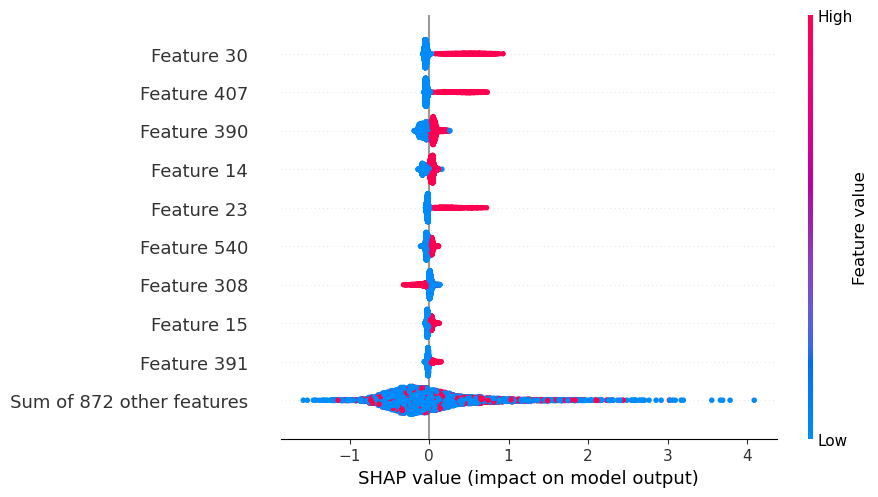

In [241]:
shap.plots.beeswarm(shap_values)

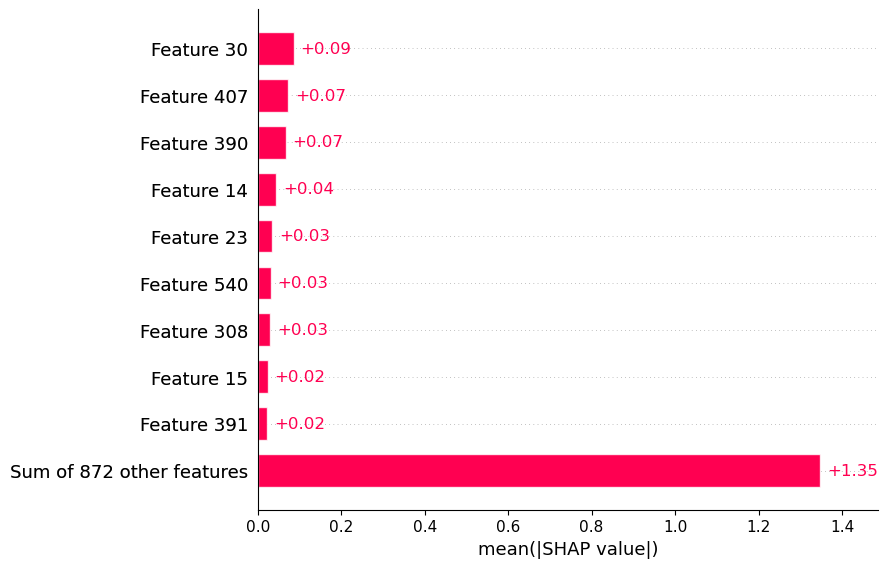

In [242]:
shap.plots.bar(shap_values)